In [428]:
import numpy as np

In [429]:
def activation_ReLU(x):
    return np.maximum(0, x)

def activation_Sigmoid(x):
    return 1 / (1 + np.exp(-x))

def activation_Tanh(x):
    return np.tanh(x)

def activation_Softmax(x):
    max_x = np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x - max_x)
    sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
    return exp_x / sum_exp_x


In [430]:
a = np.array([[0.9, 0.1, 0.8],
             [0.3, 0.5, 0.2],
             [0.4, 0.5, 0.7],
             [0.1, 0.4, 0.6]])
w = np.array([[0.2, -0.5, 0.3, -0.1],
             [0.1, 0.4, -0.2, 0.6],
             [-0.2, -0.1, 0.3, 0.4]])
# 输入的列数要和权重的行数相同

# bias的个数要和权重的行数相同
b = 0.3

# 权重的列数为神经元的个数，行数为输入的个数

sum1 = np.dot(a, w) + b
a1 = activation_ReLU(sum1)
# a1的维度是4*4，因为a的维度是4*3，w的维度是3*4，b的维度是1*4
a1

array([[0.33, 0.  , 0.79, 0.59],
       [0.37, 0.33, 0.35, 0.65],
       [0.29, 0.23, 0.53, 0.84],
       [0.24, 0.35, 0.43, 0.77]])

In [431]:
def create_weights(n_inputs, n_neurons):
    return np.random.randn(n_inputs, n_neurons)

def create_bias(n_neurons):
    return np.random.randn(n_neurons)

In [432]:
weights1 = create_weights(3, 4)
bias1 = create_bias(4)

weights2 = create_weights(4, 5)
bias2 = create_bias(5)

weights3 = create_weights(5, 2)
bias3 = create_bias(2)

sum1 = np.dot(a, weights1) + bias1
a1 = activation_ReLU(sum1)

sum2 = np.dot(a1, weights2) + bias2
a2 = activation_ReLU(sum2)

sum3 = np.dot(a2, weights3) + bias3
a3 = activation_Sigmoid(sum3)

a3

array([[0.15576075, 0.97276785],
       [0.3870771 , 0.60043144],
       [0.61646056, 0.49763921],
       [0.69349498, 0.29030971]])

将权重与偏置，放入面向对象的类中

**面向对象的层**

In [433]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases = np.random.randn(n_neurons)
        
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases

    def get_weight_adjust_matrix(self, preWeight_v, afterWeight_d):
        weight_adjust_matrix = np.full(self.weights.shape, 0.)

        print('preWeight_v.shape: ', preWeight_v.shape)
        print('afterWeight_d.shape: ', afterWeight_d.shape)
        print('weight_adjust_matrix.shape: ', weight_adjust_matrix.shape)

        for i in range(self.weights.shape[0]):
            weight_adjust_matrix += np.outer(preWeight_v[i], afterWeight_d[i])
            

        return weight_adjust_matrix/self.weights.shape[0]
        

layer1 = Layer_Dense(3, 4)
layer2 = Layer_Dense(4, 5)
layer3 = Layer_Dense(5, 2)

layer1.forward(a)
layer2.forward(layer1.output)
layer3.forward(layer2.output)
layer3.output

array([[-11.12134508,  -6.2419167 ],
       [ -5.98956474,   0.66606211],
       [ -6.13404192,  -2.29223489],
       [ -2.13227106,  -1.57506921]])

**面向对象的网络**

In [434]:
N_DATA = 9
N_DIM = 8
NET_SHAPE = [N_DIM] + [5, 6, 4, 2]
BATCH_SIZE = N_DATA

class NeuralNetwork:
    def __init__(self, net_shape):
        self.layers = []
        for i in range(len(net_shape) - 1):
            self.layers.append(Layer_Dense(net_shape[i], net_shape[i + 1]))
        self.shape = net_shape

    def forward(self, inputs):
        '''
        inputs: np.array, shape = (n_data, n_neurons)
        
        return: np.array, shape = (n_data, n_neurons)
        '''
        self.outputs = [inputs]
        for layer in self.layers[:-1]:
            layer.forward(self.outputs[-1])
            layer.output = self.activation_ReLU(layer.output)
            self.outputs.append(layer.output)
        self.layers[-1].forward(self.outputs[-1])
        self.layers[-1].output = self.activation_Softmax(self.layers[-1].output)
        self.outputs.append(self.layers[-1].output)
        return self.outputs[-1]
    
    def classify(self, output = None):
        '''
        output: np.array, shape = (n_data, n_neurons)
        
        return: np.array, shape = (n_data, n_neurons)
        '''
        if output is None:
            output = self.layers[-1].output
        return np.rint(output[:, 1])

    def cross_entropy(self, y_pred, y_true):
        '''
        y_pred: np.array, shape = (n_data, n_neurons)
        y_true: np.array, shape = (n_data, n_neurons)
        
        return: np.array, shape = (n_data, 1)
        '''
        y_true = np.concatenate((y_pred, 1 - y_pred), axis=0).copy()
        y_pred = np.concatenate((y_pred, 1 - y_pred), axis=0).copy()

        y_pred[y_pred == 0], y_pred[y_pred == 1] = 1e-15, 1 - 1e-15
        y_true[y_true == 0], y_true[y_true == 1] = 1e-15, 1 - 1e-15

        cross_entropy = -np.sum(y_true * np.log(y_pred), axis=1, keepdims=True)

        return cross_entropy
    
    def loss(self, y_pred, y_true):
        '''
        y_pred: np.array, shape = (n_data, n_neurons)
        y_true: np.array, shape = (n_data, n_neurons)
        
        return: float
        '''
        return np.mean(self.cross_entropy(y_pred, y_true))
    
    def accuracy(self, y_pred, y_true):
        return np.mean(np.rint(y_pred) == y_true)
    
    def get_final_layer_preAct_demands(self, y_pred, y_true):
        '''
        y_pred: np.array, shape = (n_data, n_neurons)
        y_true: np.array, shape = (n_data, n_neurons)
        
        return: np.array, shape = (n_data, n_neurons)
        '''
        y_pred = np.array([np.array([y, 1 - y]) for y in y_pred]).reshape(-1, 2).copy()
        y_true = np.array([np.array([y, 1 - y]) for y in y_true]).reshape(-1, 2).copy()
        
        
        for i in range(len(y_true)):
            if np.dot(y_true[i], y_pred[i]) > 0.5:
                y_true[i] = np.zeros_like(y_true[i])
            else:
                y_true[i] = y_true[i] * 2 - 1

        return y_true
    
    def activation_Softmax(self, x):
        '''
        x: np.array, shape = (n_data, n_neurons)
        
        return: np.array, shape = (n_data, n_neurons)
        '''
        max_x = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - max_x)
        sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
        return exp_x / sum_exp_x
    
    def activation_ReLU(self, x):
        return np.maximum(0, x)

    def normalize(self, x):
        '''
        x: np.array, shape = (n_data, n_neurons)
        
        return: np.array, shape = (n_data, n_neurons)
        '''
        max_x = np.max(np.absolute(x), axis=1, keepdims=True)
        scale_rate = np.where(max_x == 0, 1, 1/max_x)
        return x * scale_rate
    
    def create_data(self, n_data, n_dim):
        '''
        n_data: int
        n_dim: int
        
        return: np.array, shape = (n_data, n_dim)
        '''
        x = np.random.randn(n_data, n_dim)
        y = np.zeros((n_data, 1))
        for i in range(n_data):
            if np.square(x[i][0]) + np.square(x[i][1]) < 1:
                y[i][0] = 1
            else:
                y[i][0] = 0
        return np.concatenate((x, y), axis=1)
    
    
        


ReLU激活函数不适合输出层，因为输出层的值要符合概率分布，需要在0-1之间，所以使用Sigmoid/SoftMax激活函数

In [435]:
def activation_Softmax(x):
    max_x = np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x - max_x)
    sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
    return exp_x / sum_exp_x

Softmax为何要减去最大值（向左平移）：防止指数爆炸，因为指数函数的值会很大，所以减去最大值，可以让指数函数的值变小，同时不改变$dx$相同时，$e^{dx}$指数的比值

**数据的标准化**

In [436]:
def normalize(x):
    max_x = np.max(np.absolute(x), axis=1, keepdims=True)
    scale_rate = np.where(max_x == 0, 1, 1/max_x)
    return x * scale_rate

**数据生成**


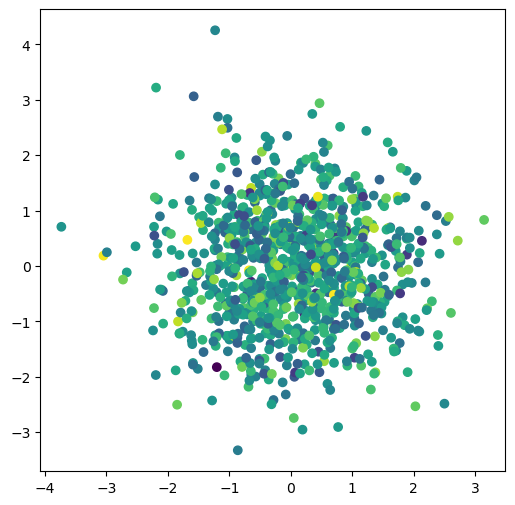

In [437]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

N_DATA = 9
N_DIM = 8
NET_SHAPE = [N_DIM] + [5, 6, 4, 2]

def create_data(n_data, n_dim):
    x = np.random.randn(n_data, n_dim)
    y = np.zeros((n_data, 1))
    for i in range(n_data):
        if np.square(x[i][0]) + np.square(x[i][1]) < 1:
            y[i][0] = 1
        else:
            y[i][0] = 0
    return np.concatenate((x, y), axis=1)

plt.figure(figsize=(6,6))
data = create_data(1000, N_DIM)
plt.scatter(data[:,0], data[:,1], c=data[:,2])
plt.show()


In [438]:
N_DATA = 9
N_DIM = 8
NET_SHAPE = [N_DIM] + [5, 6, 4, 2]

data = create_data(N_DATA, N_DIM)
inputs = data[:, :N_DIM]
labels = data[:, N_DIM:]

network = NeuralNetwork(NET_SHAPE)
print(network.shape)

output = network.forward(inputs)
print(output)
output = network.classify(output)

print(output, labels.flatten())
demands = network.get_final_layer_preAct_demands(output, labels)
print('demands:\n', demands)

print(network.layers[-1].weights)
network.layers[-1].get_weight_adjust_matrix(network.layers[-2].output, demands)


[8, 5, 6, 4, 2]
[[9.72007522e-01 2.79924780e-02]
 [9.90416938e-01 9.58306176e-03]
 [9.99999770e-01 2.29511954e-07]
 [9.90558436e-01 9.44156438e-03]
 [9.78129938e-01 2.18700621e-02]
 [9.86598641e-01 1.34013595e-02]
 [9.83230797e-01 1.67692033e-02]
 [9.55283850e-01 4.47161498e-02]
 [9.85552731e-01 1.44472690e-02]]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 1. 1. 1. 0. 1. 0. 0.]
demands:
 [[ 0.  0.]
 [ 0.  0.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 0.  0.]
 [ 1. -1.]
 [ 0.  0.]
 [ 0.  0.]]
[[ 1.19664681  0.72774339]
 [-0.37389478  0.115548  ]
 [ 0.47914701 -0.71910562]
 [-0.29344176 -0.23714812]]
preWeight_v.shape:  (9, 4)
afterWeight_d.shape:  (9, 2)
weight_adjust_matrix.shape:  (4, 2)


array([[ 5.65374577, -5.65374577],
       [ 0.09538432, -0.09538432],
       [ 1.83289802, -1.83289802],
       [ 5.13223141, -5.13223141]])

In [439]:
def get_weight_adjust_matrix(val, dem):
    pla_wght = np.full((len(val), len(dem)), 1)
    print(pla_wght)
    pla_wght_T = pla_wght.T
    print(pla_wght_T)
    tem1 = (pla_wght_T*val)
    print(tem1)
    tem2 = tem1.T
    print(tem2)
    tem3 = tem2*dem
    print(tem3)

pre_val = np.array([1,2,3,4,5])
after_dem = np.array([1,0,1])

print(get_weight_adjust_matrix(pre_val, after_dem))

# 叉乘pre_val和after_dem，给出代码

np.outer(pre_val, after_dem)

[[1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
[[1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]]
[[1 1 1]
 [2 2 2]
 [3 3 3]
 [4 4 4]
 [5 5 5]]
[[1 0 1]
 [2 0 2]
 [3 0 3]
 [4 0 4]
 [5 0 5]]
None


array([[1, 0, 1],
       [2, 0, 2],
       [3, 0, 3],
       [4, 0, 4],
       [5, 0, 5]])

当然，我将尽量详细地介绍神经网络中的反向传播算法及其数学原理。

### 神经网络简介

神经网络由一系列的神经元组成，这些神经元通常被组织在不同的层次中。最简单的神经网络包括一个输入层、一个或多个隐藏层以及一个输出层。每个神经元接收来自前一层神经元的输入，进行加权求和，再通过一个激活函数生成输出。

### 反向传播算法概述

反向传播算法（Backpropagation）是一种训练多层前馈神经网络的方法。它通过计算损失函数关于神经网络权重的梯度来调整网络的权重，以此来最小化损失函数。这个过程包含两个主要步骤：前向传播（Forward Propagation）和反向传播（Backward Propagation）。

#### 前向传播

1. **输入信号的传递**：输入数据被传递到隐藏层，然后到输出层。
2. **计算输出**：每个神经元的输出由激活函数决定，通常是非线性的，如ReLU、Sigmoid或Tanh。

#### 反向传播

1. **计算损失**：使用损失函数（如均方误差、交叉熵等）计算预测值和真实值之间的误差。
2. **传递误差**：从输出层开始，将误差向后传递到隐藏层，直至输入层。
3. **权重更新**：使用梯度下降算法或其变种（如SGD、Adam等）来更新权重，以减少损失。

### 数学原理

假设我们有一个简单的神经网络，它包括输入层、一个隐藏层和输出层。设$ \mathbf{x} $是输入，$ \mathbf{y} $是输出，$ \mathbf{z} $是隐藏层的输出，$ W_1 $和$ W_2 $是权重矩阵，$ b_1 $和$ b_2 $是偏置向量。

#### 前向传播

隐藏层的输出：
$$ \mathbf{z} = f(W_1 \mathbf{x} + b_1) $$
输出层的输出：
$$ \hat{\mathbf{y}} = g(W_2 \mathbf{z} + b_2) $$
其中，$ f $和$ g $是激活函数。

#### 反向传播

定义损失函数：
$$ \mathcal{L}(\hat{\mathbf{y}}, \mathbf{y}) $$
计算输出层权重的梯度：
$$ \frac{\partial \mathcal{L}}{\partial W_2} = \frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} \cdot \frac{\partial \hat{\mathbf{y}}}{\partial W_2} $$
计算隐藏层权重的梯度：
$$ \frac{\partial \mathcal{L}}{\partial W_1} = \frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}} \cdot \frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{z}} \cdot \frac{\partial \mathbf{z}}{\partial W_1} $$
权重更新：
$$ W_1 = W_1 - \eta \frac{\partial \mathcal{L}}{\partial W_1} $$
$$ W_2 = W_2 - \eta \frac{\partial \mathcal{L}}{\partial W_2} $$
其中，$ \eta $是学习率。

### 小结

反向传播算法是一种高效的神经网络训练方法。通过计算损失函数关于每个权重的梯度，并按照这个梯度更新权重，神经网络能够学习到将输入映射到正确输出的函数。这个过程涉及到复杂的链式求导，但可以通过自动微分技术（例如TensorFlow或PyTorch中的自动梯度计算）来高效实现。

在机器学习中，损失函数（Loss Function）是用来估计模型的预测值与实际值之间的不一致程度。它是一个非负的实值函数，通常用于神经网络的训练过程中。在训练神经网络时，目标是找到能够最小化损失函数的模型参数。以下是一些常用的损失函数及其数学原理：

### 1. 均方误差损失（Mean Squared Error, MSE）

适用于回归问题。计算方法是预测值与实际值之差的平方的平均值。

$$ MSE(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

其中，$ y $是实际值，$ \hat{y} $是预测值，$ n $是样本数量。

### 2. 交叉熵损失（Cross-Entropy Loss）

适用于分类问题。对于二分类问题，交叉熵损失可以定义为：

$$ H(y, \hat{y}) = -\sum_{i=1}^{n} [y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)] $$

对于多分类问题，交叉熵损失扩展为：

$$ H(y, \hat{y}) = -\sum_{i=1}^{n} \sum_{j=1}^{C} y_{ij} \log(\hat{y}_{ij}) $$

其中，$ C $是类别数，$ y_{ij} $是第$ i $个样本是否属于类别$ j $的指示（0或1），$ \hat{y}_{ij} $是模型预测第$ i $个样本属于类别$ j $的概率。

### 3. Hinge损失

主要用于支持向量机（SVM）中，但也可用于神经网络的分类问题。对于二分类问题，Hinge损失定义为：

$$ Hinge(y, \hat{y}) = \sum_{i=1}^{n} \max(0, 1 - y_i \cdot \hat{y}_i) $$

其中，$ y_i $是实际标签（+1或-1），$ \hat{y}_i $是预测值。

### 4. Huber损失

Huber损失是均方误差和绝对误差的结合，对于较小的误差，它类似于均方误差，对于较大的误差，它则变成线性。这使得Huber损失对异常值更加鲁棒。

$$ Huber(y, \hat{y}) = \begin{cases} \frac{1}{2}(y - \hat{y})^2 & \text{for } |y - \hat{y}| \le \delta, \\ \delta(|y - \hat{y}| - \frac{1}{2} \delta) & \text{otherwise.} \end{cases} $$

其中，$ \delta $是一个设定的阈值。

### 5. 对数损失（Log Loss）

对数损失是交叉熵损失的一个特例，主要用于二分类问题。

$$ LogLoss(y, \hat{y}) = -\frac{1}{n} \sum_{i=1}^{n} [y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)] $$

### 小结

选择合适的损失函数对于训练有效的神经网络模型至关重要。不同的问题类型（如回归、分类）和数据特性（如是否存在异常值）可能需要不同的损失函数。理解各种损失函数的数学原理有助于更好地进行模型选择和优化。



在神经网络中，激活函数（Activation Function）是用来向网络引入非线性特征的关键组成部分。激活函数决定了一个节点（神经元）是否应该被激活，即是否对输入的信息做出反应。它们帮助神经网络学习复杂的模式、决策边界。以下是一些常用的激活函数及其数学原理：

### 1. Sigmoid函数

Sigmoid函数是一种将输入值映射到0和1之间的激活函数，通常用于二分类问题。

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

Sigmoid函数的输出范围是(0,1)，它可以将任意值映射到这个区间内。

### 2. 双曲正切函数（Hyperbolic Tangent, tanh）

tanh函数是sigmoid函数的变体，将输入映射到-1和1之间。

$$ \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} $$

tanh函数的输出范围是(-1,1)，适用于隐藏层中。

### 3. ReLU（Rectified Linear Unit）

ReLU函数是目前最常用的激活函数之一，特别是在隐藏层中。

$$ ReLU(x) = \max(0, x) $$

ReLU函数的输出是输入值本身（如果输入是正数），否则输出0。

### 4. Leaky ReLU

Leaky ReLU是ReLU的改进版本，旨在解决ReLU中的“死神经元”问题。

$$ LeakyReLU(x) = \max(\alpha x, x) $$

其中，$ \alpha $是一个很小的正常数，例如0.01。

### 5. Softmax函数

Softmax函数通常用于多分类神经网络输出层，将输出值映射为概率分布。

$$ Softmax(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}} $$

其中，$ x_i $是向量$ x $的第$ i $个分量。

### 小结

激活函数的选择对神经网络的性能有显著影响。ReLU及其变种通常是隐藏层的首选，因为它们的计算效率高且能够减轻梯度消失问题。Sigmoid和Softmax更适合用于输出层，特别是在分类问题中。通过激活函数的非线性特性，神经网络能够学习并建模复杂的非线性关系。